In [1]:
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch
import os
import torchvision
import numpy as np

dtype = torch.float

In [2]:
dataset_folder = os.path.join('cached_datasets')

train_dataset = torchvision.datasets.FashionMNIST(dataset_folder, train=True,
                                           transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(dataset_folder, train=False,
                                          transform=None, target_transform=None, download=True)

# Standardize data
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0], -1) / 255
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0], -1) / 255

y_train = np.array(train_dataset.targets, dtype=np.int)
y_test  = np.array(test_dataset.targets, dtype=np.int)

# Network structure
num_inputs = 28 * 28
hidden_1_neurons = 400
hidden_2_neurons = 100
num_outputs = 10

time_step = 1e-3
num_steps = 100
batch_size = 256

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

159.1%C:\Users\itznu\anaconda3\envs\data-science\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting cached_datasets\FashionMNIST\raw\train-images-idx3-ubyte.gz to cached_datasets\FashionMNIST\raw
Extracting cached_datasets\FashionMNIST\raw\train-labels-idx1-ubyte.gz to cached_datasets\FashionMNIST\raw
Extracting cached_datasets\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to cached_datasets\FashionMNIST\raw
Extracting cached_datasets\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to cached_datasets\FashionMNIST\raw
Processing...
Done!


In [3]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value
    tmax -- The maximum time returned
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index], device=device, dtype=torch.long)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1


class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [4]:
# initialization of the network
weight_scale = 6 * (1.0-beta)
w1 = torch.empty((num_inputs, hidden_1_neurons), device=device, dtype=dtype, requires_grad=True)
w2 = torch.empty((hidden_1_neurons, hidden_2_neurons), device=device, dtype=dtype, requires_grad=True)
w3 = torch.empty((hidden_2_neurons, num_outputs), device=device, dtype=dtype, requires_grad=True)

torch.nn.init.normal_(w1, mean=0.0, std=weight_scale / np.sqrt(num_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale / np.sqrt(hidden_1_neurons))
torch.nn.init.normal_(w3, mean=0.0, std=weight_scale / np.sqrt(hidden_2_neurons))

tensor([[-5.4615e-02, -2.6208e-02, -1.8990e-03, -9.8272e-02,  2.7721e-02,
         -3.7305e-02, -4.7870e-02,  3.0612e-02, -1.0448e-01, -2.6787e-03],
        [ 8.7552e-03,  1.2017e-01, -2.4053e-02,  1.0626e-03, -3.7044e-02,
         -3.6515e-02,  9.3156e-02,  7.3120e-03,  7.7473e-02, -1.2317e-01],
        [ 2.2835e-03, -3.8660e-02, -2.2359e-02, -6.6467e-02, -1.1967e-02,
          7.6439e-02, -2.6147e-02, -4.1303e-02,  8.2683e-02,  1.6131e-02],
        [-4.1177e-02, -1.4262e-02, -1.0349e-02, -4.3589e-03,  3.2278e-02,
         -1.0232e-02, -7.7661e-02, -2.7474e-02, -1.5275e-02, -4.3727e-02],
        [-5.0640e-03, -7.2224e-02, -5.3680e-02,  1.3708e-01,  2.7200e-02,
          2.6782e-02, -1.4277e-01,  1.0471e-02, -6.4156e-02,  1.2150e-01],
        [ 9.3228e-02, -1.3189e-02, -7.5031e-02, -8.5655e-02, -1.0981e-01,
         -1.2461e-02, -2.2109e-03,  5.8592e-02,  1.7189e-02,  5.4864e-02],
        [-6.0973e-02,  4.5472e-02, -1.1718e-01, -4.9780e-02,  4.7109e-02,
          9.4628e-02,  9.0922e-0

In [5]:
def run_snn(inputs):
    h1 = torch.einsum('abc,cd->abd', (inputs, w1))
    syn_hidden_1 = torch.zeros((batch_size, hidden_1_neurons), device=device, dtype=dtype)
    mem_hidden_1 = torch.zeros((batch_size, hidden_1_neurons), device=device, dtype=dtype)

    mem_rec_hidden_1 = [mem_hidden_1]
    spike_rec_hidden_1 = [mem_hidden_1]

    for t in range(num_steps):
        mem_threshold = mem_hidden_1 - 1.0
        out = spike_fn(mem_threshold)
        rst = torch.zeros_like(mem_hidden_1)
        c = (mem_threshold > 0)
        rst[c] = torch.ones_like(mem_hidden_1)[c]

        new_syn = alpha * syn_hidden_1 + h1[:, t]
        new_mem = beta * mem_hidden_1 + syn_hidden_1 - rst
        mem_hidden_1 = new_mem
        syn_hidden_1 = new_syn

        mem_rec_hidden_1.append(mem_hidden_1)
        spike_rec_hidden_1.append(out)

    spike_rec_hidden_1 = torch.stack(spike_rec_hidden_1, dim=1)
    mem_rec_hidden_1 = torch.stack(mem_rec_hidden_1, dim=1)

    h2 = torch.einsum('abc,cd->abd', (spike_rec_hidden_1, w2))
    syn_hidden_2 = torch.zeros((batch_size, hidden_2_neurons), device=device, dtype=dtype)
    mem_hidden_2 = torch.zeros((batch_size, hidden_2_neurons), device=device, dtype=dtype)

    mem_2_rec = [mem_hidden_2]
    spike_2_rec = [mem_hidden_2]

    for t in range(num_steps):
        mem_threshold = mem_hidden_2 - 1.0
        out = spike_fn(mem_threshold)
        rst = torch.zeros_like(mem_hidden_2)
        c = (mem_threshold > 0)
        rst[c] = torch.ones_like(mem_hidden_2)[c]

        new_syn = alpha * syn_hidden_2 + h2[:, t]
        new_mem = beta * mem_hidden_2 + syn_hidden_2 - rst
        mem_hidden_2 = new_mem
        syn_hidden_2 = new_syn

        mem_2_rec.append(mem_hidden_2)
        spike_2_rec.append(out)

    mem_2_rec = torch.stack(mem_2_rec, dim=1)
    spike_2_rec = torch.stack(spike_2_rec, dim=1)

    h3 = torch.einsum('abc,cd->abd', (spike_2_rec, w3))
    flt = torch.zeros((batch_size, num_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size, num_outputs), device=device, dtype=dtype)

    out_rec = [out]
    for t in range(num_steps):
        new_flt = alpha * flt + h3[:, t]
        new_out = beta * out + flt

        flt = new_flt
        out = new_out
        out_rec.append(out)
    
    out_rec = torch.stack(out_rec, dim=1)
    prev_recs = [[mem_rec_hidden_1, spike_rec_hidden_1], [mem_2_rec, spike_2_rec]]

    return out_rec, prev_recs

def train(x_data, y_data, lr=1e-3, nb_epochs=10):
    params = [w1, w2, w3]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    for epoch in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, num_steps, num_inputs):
            output, _ = run_snn(x_local.to_dense())
            m, _ = torch.max(output, 1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())

        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(epoch+1,mean_loss))
        loss_hist.append(mean_loss)

    return loss_hist

def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, num_steps, num_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

Epoch 1: loss=0.84375
Epoch 2: loss=0.51504
Epoch 3: loss=0.46160
Epoch 4: loss=0.43026
Epoch 5: loss=0.40678
Epoch 6: loss=0.39004
Epoch 7: loss=0.37078
Epoch 8: loss=0.35987
Epoch 9: loss=0.35034
Epoch 10: loss=0.34012
Training accuracy: 0.88118
Test accuracy: 0.85667


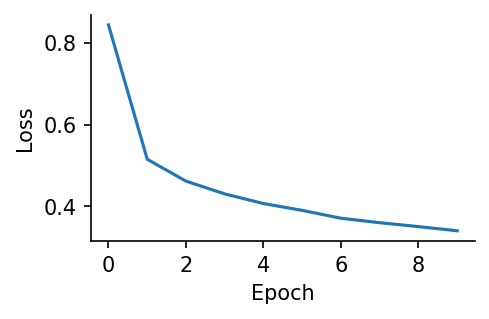

In [6]:

loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=10)
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

print("Training accuracy: %.5f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.5f"%(compute_classification_accuracy(x_test,y_test)))